# **2 - Chemical case study**

# Building a simple QSPR model using a feed forward neural network in PyTorch [[1](https://www.sciencedirect.com/science/article/pii/S0140700713003861)]

Let's get our hands dirty on a chemical engineering example! In the following, we will predict the normal boiling point of pure refrigerants with a QSPR model and an artificial neural network (ANN).

In the past decades, several models have been developed to predict properties of molecules by utilizing quantitative structure-property relationship ([QSPR](https://en.wikipedia.org/wiki/Quantitative_structure%E2%80%93activity_relationship)) modeling. In QSPR, the modeling process can be broken down into two steps: First, QSPR models introduce molecular descriptors $D = [d_1, d_2, ..., d_n]^T$ that depend on the structure of a molecule $m$. Second, a regression model $F(D):D → \hat{p}$ is fitted that predicts a property $\hat{p}$ as a function of $D$. The regression model is either linear or nonlinear, depending on the QSPR. QSPR models differ in the way they encode the molecular structure. Various descriptors have been used including structural group counts, the number of aromatic bonds, and topological indices, such as the [Wiener Index](https://en.wikipedia.org/wiki/Wiener_index) or branching indices. Development of QSPR models depends on the choice of informative descriptors, a selection process that requires domain knowledge and intuition. For the sake of time, we skip this process and use predefined descriptors. In our case study, the property $\hat{p}$ is the normal boiling point and the regression model is of course an ANN!

---
**Increase the model complexity by adding one (or more) hidden layers. 

Opposite to matlab, we do not have all functionalities pre installed in Python. Therefore, the first step for a project is always to install packages which extend our function library. Here, we install the following packages:
- *torch*: The PyTorch package is the most important one for this lab and inherits a variety of useful functions for machine learning.
- *scipy*: Package for scientific computing and technical computing with algorithms for optimization, interpolation, statistics, etc..
- *matplotlib*: Provides plotting functions similar to matlab.
- *tqdm*: Allows to print progress bar of for loops

In [22]:
# install dependencies
!pip install torch
!pip install scipy
!pip install matplotlib

You should consider upgrading via the 'c:\users\lschulzebalhor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lschulzebalhor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lschulzebalhor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


## 2.1 Python preparation

### Import packages

In the next step, we import the previously installed packages into our script.

Additional to the packages from the previous notebook we also need the $StandardScaler$ from scikit-learn for normalization of the dataset and the $DataLoader$ for additional training options. We also use *pandas* to handle the dataset we want to load from an external source.

In [148]:
from scipy import stats # statistics tool for prob. dens. fun.
from sklearn.preprocessing import StandardScaler # normalizes a dataset
from sklearn.model_selection import train_test_split # randomly splits a dataset
import pandas as pd # pandas package for data manipulation and analysis
import numpy as np # numerical calculations in python
import matplotlib.pyplot as plt # plotting similar to matlab
import torch # PyTorch: the general machine learning framework in Python
import torch.nn as nn # the artificial neural network module in PyTorch
import torch.optim as optim  # contains optimizers for the backpropagation
from torch.utils.data import DataLoader

### Set the seed

To make our results reproducable, we need to set a so-called "seed". Machine Learning includes stochastic processes in the weight/bias initialization and the backpropagation. By setting a seed in the program we make sure that always the same random numbers are chosen. Otherwise, we would get different results everytime we run this script, which is not nice for teaching purposes.

In [149]:
torch.manual_seed(0)
np.random.seed(0)

## 2.2 - Prepare dataset

The next line reads the dataset from an external .csv file into a Pandas dataframe object.

In [150]:
# Read the data
data = pd.read_table('boiling_point_data.csv', sep=',')
data

,component,formula,descriptor: R1e+,descriptor: MATS1m,descriptor: X1sol,descriptor: Me,descriptor: ESpm02d,experiment: Tboil /K
0,"1,1,1,2,2,3,3,4,4-Nonafluorobutane",C4HF9,0.252,-0.187,1.914,1.31,4.159,288.25
1,"1,1,1,2-Tetrachloro-2-fluoroethane",C2HCl4F,0.240,-0.303,3.664,1.22,3.267,390.15
2,"1,1,1,2-Tetrachloroethane",C2H2Cl4,0.384,-0.400,3.664,1.18,3.077,403.75
3,"1,1,1,2-Tetrafluoroethane",C2H2F4,0.442,-0.400,1.000,1.30,3.270,247.05
4,"1,1,1-Trichloro-2-fluoroethane",C2H2Cl3F,0.442,-0.284,2.750,1.21,3.070,366.00
...,...,...,...,...,...,...,...,...
187,"2,2,4-Trimethylpentane",C8H18,0.117,1.000,3.417,0.96,3.045,372.37
188,"1,2-Dichloropropane",C3H6Cl2,0.149,-0.167,2.912,1.02,2.630,369.55
189,1-Chlorobutane,C4H9Cl,0.141,-0.062,2.768,0.98,2.244,351.55
190,Octane,C8H18,0.103,1.000,3.914,0.96,2.565,398.82


The table contains several refrigerents with different descriptors and their normal boiling point obtained from experiments. The descriptors are the following:
| Molecular Descriptor | Descriptor type | Descriptor definition |
| --- | --- | --- |
| R1e+ | GETAWAY descriptors | R maximal autocorrelation of lag 1/weighted by atomic Sanderson electronegativities |
| MATS1m | 2D autocorrelation indices | Moran autocorrelation - lag 1/weighted by atomic masses |
| X1sol | Connectivity indices | Solvation connectivity index chi-1 |
| Me | Constitutional descriptors | Mean atomic Sanderson electronegativity (scaled on Carbon atom) |
| ESpm02d | Edge adjacency indices | Spectral moment 02 from edge adj. matrix weighted by dipole moments |


We join all descriptors in one array for each molecule. Hence, we get a 2D array. This is our input array *x*. We show examplarily the array that describes the first molecule.

---
**Try out how many descriptors we actually need to make a reasonable prediction:**

In [182]:
x = np.array(data[['descriptor: R1e+', 'descriptor: MATS1m',
                    'descriptor: X1sol', 'descriptor: Me',
                    'descriptor: ESpm02d']].values.tolist())
x[0]

array([ 0.252, -0.187,  1.914])

---

However, there is a problem if we just concatenate the different descriptors: They have quite different means and variances. This has a negative effect on the training of our ANN. For instance, a descriptor with very high values has a bigger effect than one with values close to 0 even though both might be equallly important. Hence, we need to standardize our dataset.

First we define a function that can plot the normal distribution for the columns of a 2D array.

In [183]:
def plot_norm(array):
    for n in range(array[0].size): # plot the normal distribution for each descriptor
        mu = np.mean(array[:,n]) # get the mean
        std = np.std(array[:,n]) # get the standard deviation
        input = np.linspace(mu - 3*std, mu + 3*std, 100) # range of 3 st. deviations
        plt.plot(input, stats.norm.pdf(input, mu, std)) # plot normal dist of one descriptor
    plt.title('Normal distribution')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

Then we plot the normal distributions of the raw descriptor data.

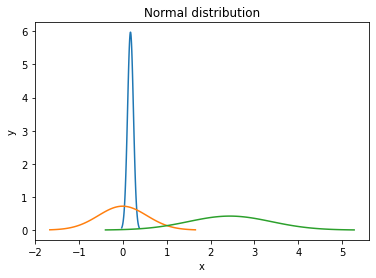

In [184]:
plot_norm(x)

Now we can use the scikit-learn *StandardScaling* to normalize our data. It normalizes the data to zero mean and a unit variance (standard deviation = 1). This improves the training performance of the neural network. If we plot the normal distribution again, we see that all descriptors share the same distribution now.

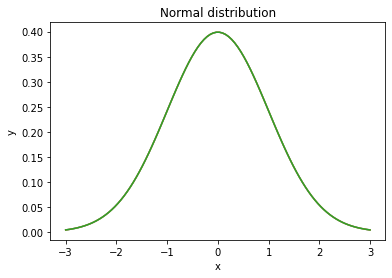

In [185]:
st = StandardScaler()
x = st.fit_transform(x)
plot_norm(x)

Our target values for the regression *y* are simply the boiling points obtained from experiments.

In [186]:
y = data['experiment: Tboil /K'].values

We also need to split the dataset in training, validation and test data. In the first step we will split the data in training and remaining dataset. Now since we want the valation and test size to be equal (10% each of overall data), we have to define *val_size=0.5* (that is 50% of remaining data).

In [187]:
# first split
x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size=0.7)

# second split
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=0.5)

Then we transform the numpy arrays into PyTorch tensors. In this notebook we will introduce PyTorch datasets and dataloaders, therefore we do not need to unsqueeze the tensors or change the datatype.

In [188]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

Pytorch works with *Dataset*s and *DataLoader*s (more information [here](https://pytorch.org/docs/stable/data.html)) to feed minibatches to the model during training. Using the DataLoader allows for advanced training methods. It’s easy to create a dataset from the already created tensors. We print out one example data point, containing the input and output tensor.

In [189]:
train_set = torch.utils.data.TensorDataset(x_train, y_train)
val_set = torch.utils.data.TensorDataset(x_val, y_val)
test_set = torch.utils.data.TensorDataset(x_test, y_test)

train_set[0]

(tensor([ 0.1431, -0.1922, -0.4408]), tensor(287.2500))

The train_loader will shuffle the data when an epoch has been used to prevent overfitting.

In [190]:
train_loader = DataLoader(dataset=train_set,
                            shuffle=True)
val_loader = DataLoader(dataset=val_set,
                            shuffle=False)
test_loader = DataLoader(dataset=test_set,
                            shuffle=False)

## 2.3 - Set up neural network

Besides the data we also nee to prepare our ANN. Pytorch uses a base model object and adds the layers and activations as other objects in a sequential manner. The first layer must get an input dimensions matching the data, whereas the following can deduce their input size from the previous layer. The output layer then must match the dimension of the target values. We start with a very simple model with a small hidden layer with ReLU activation. Very large networks will overfit, unless some form of regularization is put in place (such as early stopping or drop out). As the output values are continuous rather than class labels, the output dimension is a single neuron with a linear activation. Each ANN class needs a *forward* function which defines, how a signal propagates through the network.

---
**Here you can add one (or more) hidden layers to get a more complex neural network:**

In [191]:
# neural network definition
class NeuralNetwork(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(NeuralNetwork, self).__init__()
        self.architecture = nn.Sequential(
            # sequential model definition: add up layers & activation functions
            nn.Linear(in_features=n_input, out_features=n_hidden), # hidden layer
            nn.ReLU(), # activation function
            nn.Linear(in_features=n_hidden, out_features=n_output), # output layer
        )
    def forward(self, x): # feed forward path
        out = self.architecture(x)
        return out

---

## 2.4 - Train neural network

Before the  network can be trained the loss function and other hyperparameters need to be defined. The loss function is set for the usual mean squared error and the optimizer is stochastic gradient descent with a specific learning rate.

---
**This cell contains all relevant hyperparameters:**

In [192]:
#Defining the hyperparameters
hidden_size = 10 # Number of neurons in the hidden layer
learning_rate = 0.02  # The learning rate for the optimizer
epochs = 400

---

We use the hyperparameters to set up the ANN and the training process.

In [193]:
input_size = len(x[0]) # The input size should fit our fingerprint size
output_size = 1  # The target is only the boiling point, so this will be one
net = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net

NeuralNetwork(
  (architecture): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

Now comes the actual training of the neural network. We have two loss functions. The training loss and the validation loss. We use the validation loss to detect overfitting and make sure, that the model can generalize to new data.

In [194]:
train_loss = []
val_loss = []

for epoch in range(epochs):
    
    # Training pass
    running_loss = 0
    for input, target in train_loader:
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass
         
        output = net(input) # Forward pass of the mini-batch
        loss = criterion(output, target) # Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights and bias
        running_loss += loss.item()
    train_loss.append(running_loss/len(train_loader))
        
    # Validation pass
    running_val_loss = 0
    for input_val, labels_val in val_loader:
        output_val = net(input_val)
        loss_val = criterion(output_val, labels_val)
        running_val_loss += loss_val.item()
    val_loss.append(running_val_loss/len(val_loader))

    if epoch%10 == 0: # after 10 epochs we print the current status
        print("Epoch: %3i\t Training loss: %0.2F\t Validation loss: \
                %0.2F"%(epoch,(running_loss/len(train_loader)), 
                (running_val_loss/len(val_loader))))


C:\Users\lschulzebalhor\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:   0	 Training loss: 89293.05	 Validation loss:                 67201.07
Epoch:  10	 Training loss: 619.90	 Validation loss:                 567.24
Epoch:  20	 Training loss: 580.79	 Validation loss:                 475.07
Epoch:  30	 Training loss: 595.77	 Validation loss:                 473.67
Epoch:  40	 Training loss: 595.48	 Validation loss:                 506.63
Epoch:  50	 Training loss: 581.18	 Validation loss:                 596.81
Epoch:  60	 Training loss: 622.14	 Validation loss:                 518.68
Epoch:  70	 Training loss: 585.79	 Validation loss:                 595.20
Epoch:  80	 Training loss: 604.47	 Validation loss:                 482.40
Epoch:  90	 Training loss: 641.97	 Validation loss:                 522.28
Epoch: 100	 Training loss: 582.07	 Validation loss:                 581.21
Epoch: 110	 Training loss: 579.84	 Validation loss:                 464.84
Epoch: 120	 Training loss: 582.61	 Validation loss:                 487.93
Epoch: 130	 Training 

Afterwards, we plot the loss to see the training progress. The loss plot shows if adjustments need to be made to the hyperparameters.

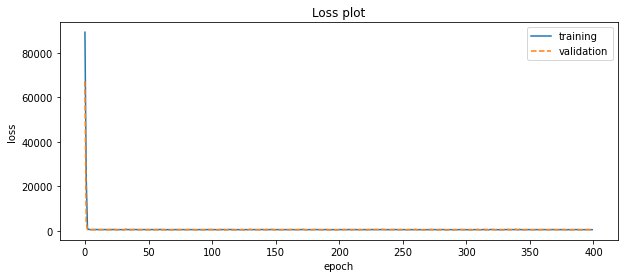

Final training loss: 
548.7961939916071


In [195]:
plt.figure(figsize=(10,4))
plt.plot(train_loss, label='training')
plt.plot(val_loss, label='validation', linestyle='--')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss plot')
plt.show()
print('Final training loss: ')
print(train_loss[-1])

## 2.5 - Evaluate neural network

In order to evaluate our model we compare the actual boiling point, which was measured in experiments, and the predicted boiling point from our neural network regression.

We switch to the evaluation mode of the model which turns of features like dropout. Then we get our predicted boiling points.

In [196]:
with torch.no_grad():
    y_pred_train = net(x_train)
    y_pred_val = net(x_val)
    y_pred_test = net(x_test)

Calculating the root mean square error can be done using the pytorch operators. The .item() method converts single element tensors to Python scalers for printing.

Training mean

In [197]:
torch.mean(( y_train - y_pred_train )**2).item()

7008.1865234375

Validation mean

In [198]:
torch.mean(( y_val - y_pred_val )**2).item()

8097.15087890625

Test mean

In [199]:
torch.mean(( y_test - y_pred_test )**2).item()

8249.9052734375

If the error on the held out test set is significantly higher than the validation set, this indicates overfitting.

Finally, lets evaluate the model visually. The full blue line is the desired output which corresponds to an exact prediction. The dashed blue lines represent the 10% error threshold.

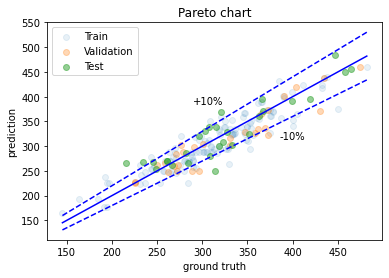

In [200]:
plt.scatter(y_train, y_pred_train, alpha=0.1, label="Train")
plt.scatter(y_val, y_pred_val, alpha=0.3, label="Validation")
plt.scatter(y_test, y_pred_test, alpha=0.5, label="Test")
plt.legend()
plt.xlabel('ground truth')
plt.ylabel('prediction')
min = np.min(data['experiment: Tboil /K'])
max = np.max(data['experiment: Tboil /K'])
plt.plot([min, max], [min, max], c="b")
plt.plot([min, max], [0.9*min, 0.9*max], c="b", linestyle='--')
plt.plot([min, max], [1.1*min, 1.1*max], c="b", linestyle='--')
plt.text(0.8*max, 0.65*max, '-10%')
plt.text(0.6*max, 0.8*max, '+10%')
plt.title('Pareto chart')
plt.show()

## 2.6 - Conclusion

In the second half of the lab we demonstrated how to use a neural network for a complex regression like a QSPR model. For five given descriptors, we created a fingerprint and used it to train the neural network.